In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPooling2D,Rescaling, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data download and exploration

In [3]:
train_images= image_dataset_from_directory('/kaggle/input/plant-disease-recognition-dataset/Train/Train', batch_size=32, image_size=(128, 128), shuffle=True)
val_images= image_dataset_from_directory('/kaggle/input/plant-disease-recognition-dataset/Validation/Validation', batch_size=32, image_size=(128, 128))
test_images= image_dataset_from_directory('/kaggle/input/plant-disease-recognition-dataset/Test/Test', batch_size=32, image_size=(128, 128))

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


In [4]:
сlass_names = list(train_images.class_names)
print(сlass_names)

['Healthy', 'Powdery', 'Rust']


In [5]:
class_counts = Counter()

for images, labels in train_images:
    class_counts.update(labels.numpy())

for class_name, count in zip(train_images.class_names, class_counts.values()):
    print(f"{class_name}: {count}")

Healthy: 430
Powdery: 458
Rust: 434


# Model construction

In [6]:
model= Sequential()
model.add(Rescaling(1./255, input_shape=(128, 128, 3)))
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.2))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,555 (2.42 MB)

 Trainable params: 635,555 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
monitor = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                      save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history=model.fit(train_images,
                  validation_data=val_images,
                  epochs=100,
                  callbacks = [monitor, checkpoint_callback, lr_scheduler])

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 929ms/step - accuracy: 0.3459 - loss: 1.0964 - val_accuracy: 0.5500 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 949ms/step - accuracy: 0.5493 - loss: 0.9035 - val_accuracy: 0.6333 - val_loss: 0.7385 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 918ms/step - accuracy: 0.7267 - loss: 0.6494 - val_accuracy: 0.8833 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 932ms/step - accuracy: 0.8842 - loss: 0.3645 - val_accuracy: 0.7667 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 918ms/step - accuracy: 0.8347 - loss: 0.4700 - val_accuracy: 0.8833 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 963ms/step - accuracy: 0.9160 - loss: 0.2550 - val_accuracy: 0.8667 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 953ms/step - accuracy: 0.9182 - l

In [81]:
def plot_epochs_accuracy_loss(history):
    fig, axs= plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(history.history['accuracy'], ax= axs[0], label='accuracy', marker="o")
    sns.lineplot(history.history['val_accuracy'],ax= axs[0], label='val_accuracy', marker="o")

    sns.lineplot(history.history['loss'], ax= axs[1], label='loss', marker="o")
    sns.lineplot(history.history['val_loss'], ax= axs[1], label='val_loss', marker="o")
    
    for ax in axs:
        ax.set_xticks(range(len(history.history['accuracy'])))
        ax.set_xticklabels(range(1, len(history.history['accuracy']) + 1))
        ax.set_xlabel('Epochs')
        ax.legend()
        ax.grid()
    plt.show()

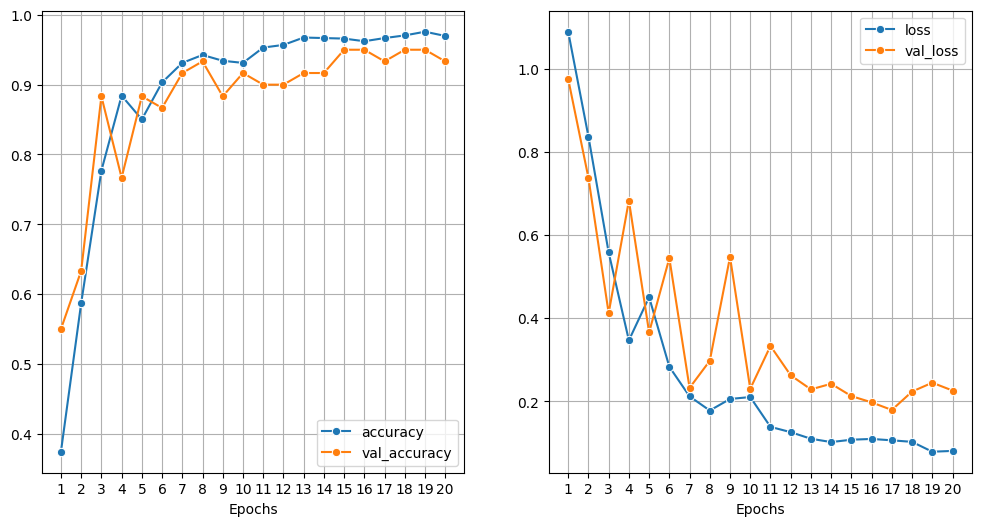

In [82]:
plot_epochs_accuracy_loss(history)

# Results processing

In [49]:
loss, acc = model.evaluate(test_images)
print(f'Test accuracy: {acc}')
print(f'Test loss: {loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.9541 - loss: 0.1939
Test accuracy: 0.95333331823349
Test loss: 0.19128738343715668


In [75]:
AUTOTUNE = tf.data.AUTOTUNE
test_images = test_images.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)
print(pred_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 698ms/step
[0 2 0 0 1 2 1 0 2 0 1 0 1 1 2 1 2 2 2 0 0 0 0 2 2 1 1 2 0 1 1 0 1 0 0 2 2
 0 0 0 0 0 2 2 1 1 2 2 2 1 2 0 2 1 2 0 0 0 2 0 0 2 1 0 0 1 1 0 1 1 0 0 0 2
 1 1 0 0 2 1 1 0 1 0 1 1 2 1 1 2 0 1 1 2 0 0 0 0 1 0 2 0 1 0 1 2 0 1 0 0 2
 1 2 0 1 2 0 2 1 1 2 0 2 2 1 2 2 2 2 1 0 0 1 2 2 0 0 2 0 2 0 1 2 0 2 1 0 1
 2 2]


In [96]:
pred_probabilities = np.max(pred_probs, axis=1)
print(pred_probabilities)

[0.99996    0.99879813 0.99993736 0.82486314 0.9998548  0.99999994
 0.98828614 0.9918646  0.99977016 0.9968756  0.98976856 0.9909105
 0.99546194 0.8813521  0.99999994 0.9985727  0.99999994 0.99999994
 0.99999994 0.9950182  0.9971543  0.9996635  0.9999977  0.99999994
 0.9999687  0.9985641  0.99840194 0.99988014 0.8712976  0.99893624
 0.99699503 0.65501845 0.98186916 0.9995224  0.85689247 0.99999994
 0.9782161  0.8501575  0.9989772  0.9999146  0.99851805 0.9950559
 0.9999967  0.99999994 0.99884945 0.9506116  0.9855659  0.99983144
 0.99999994 0.9953593  0.99999994 0.9902596  0.99999994 0.99655074
 0.9999986  0.9999897  0.97887653 0.99999136 0.99999994 0.99993855
 0.917466   0.99999887 0.9956991  0.997538   0.9999916  0.9619923
 0.92030597 0.97421634 0.99282604 0.9965858  0.9893163  0.99998647
 0.85984653 0.9996791  0.9899429  0.99508655 0.99655193 0.9999991
 0.99999934 0.9575205  0.9986195  0.9982345  0.99785674 0.99447095
 0.9964607  0.62408596 0.9996268  0.9885921  0.99909353 0.99983263

In [78]:
images=[]
true_labels=[]
for image, label in test_images:
    images.extend(image.numpy().astype("uint8"))
    true_labels.extend(label.numpy().flatten().tolist())
images = np.array(images)
print(true_labels)

[0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2]


In [86]:
class_dict = {i: сlass_names[i] for i in range(len(сlass_names))}
print(class_dict)

{0: 'Healthy', 1: 'Powdery', 2: 'Rust'}


In [88]:
print(classification_report(true_labels, pred_labels, target_names=сlass_names))

              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.93        50
     Powdery       1.00      0.90      0.95        50
        Rust       1.00      0.96      0.98        50

    accuracy                           0.95       150
   macro avg       0.96      0.95      0.95       150
weighted avg       0.96      0.95      0.95       150



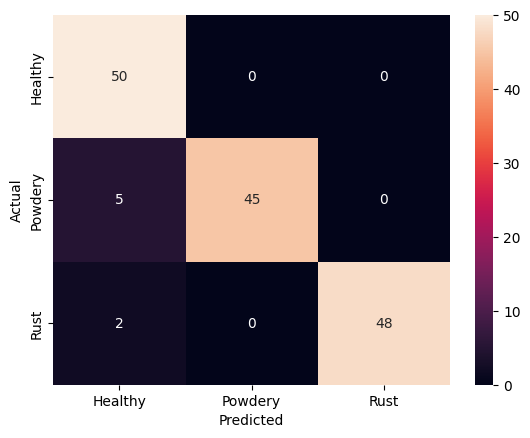

In [90]:
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, xticklabels=сlass_names, yticklabels=сlass_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Images that have been incorrectly categorised**

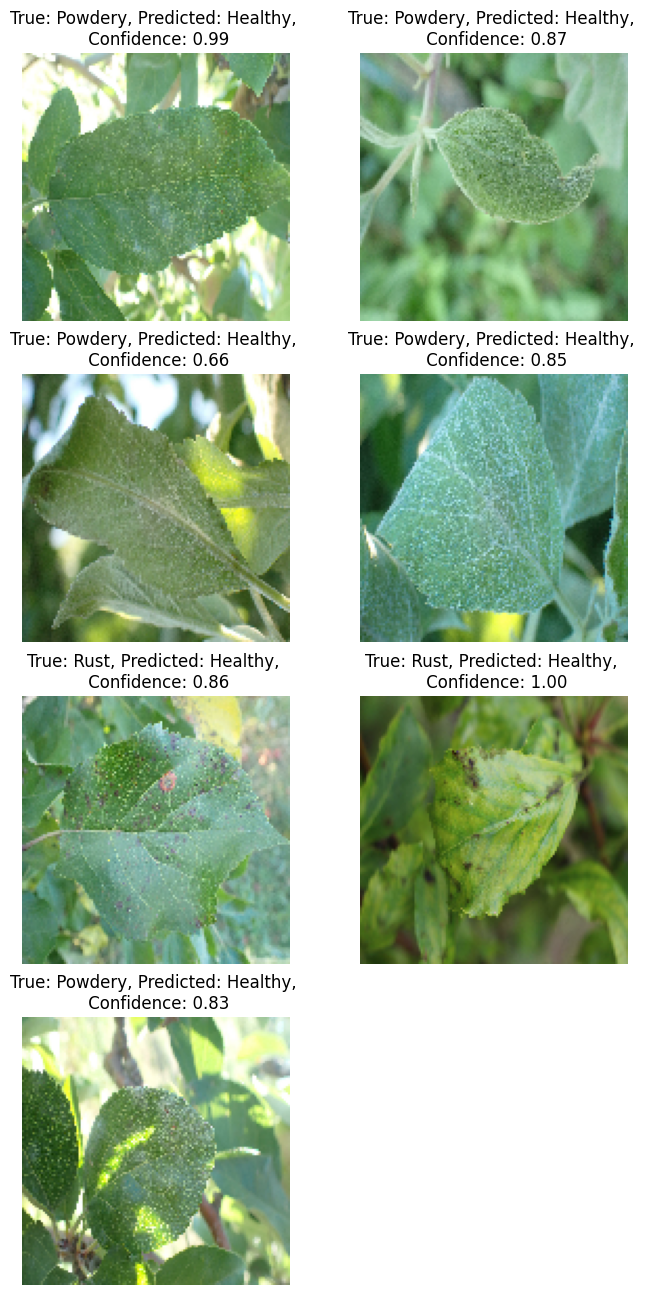

In [101]:
misclassified_images = [i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred != true]

plt.figure(figsize=(8, 16))
for i, idx in enumerate(misclassified_images):
    plt.subplot(4, 2, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {class_dict[true_labels[idx]]}, Predicted: {class_dict[pred_labels[idx]]}, \n Confidence: {pred_probabilities[idx]:.2f}")
    plt.axis('off')
plt.show()

**Some randomly selected images, out of the correctly categorised ones**

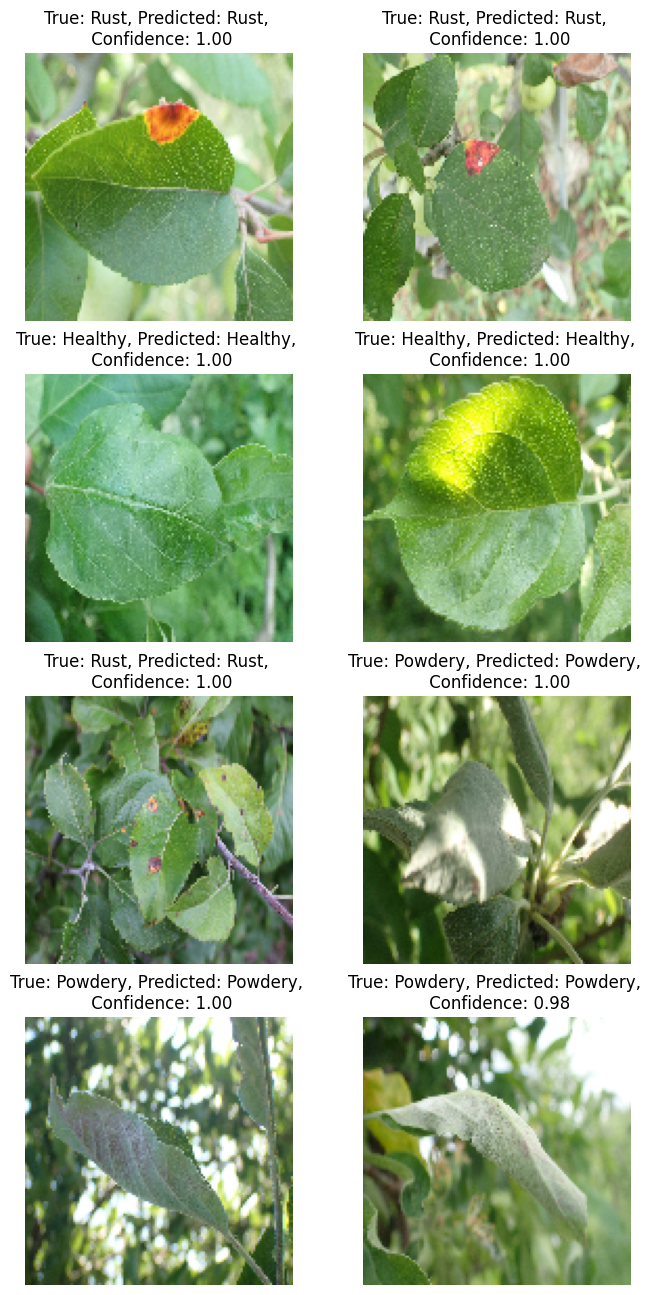

In [119]:
correct_images = [i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred == true]

plt.figure(figsize=(8, 16))
for i, idx in enumerate(correct_images[15:30:2]):
    plt.subplot(4, 2, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {class_dict[true_labels[idx]]}, Predicted: {class_dict[pred_labels[idx]]}, \n Confidence: {pred_probabilities[idx]:.2f}")
    plt.axis('off')
plt.show()

**Images that the model categorised with a low degree of confidence. A confidence level of 0.9 was chosen as the threshold value.**

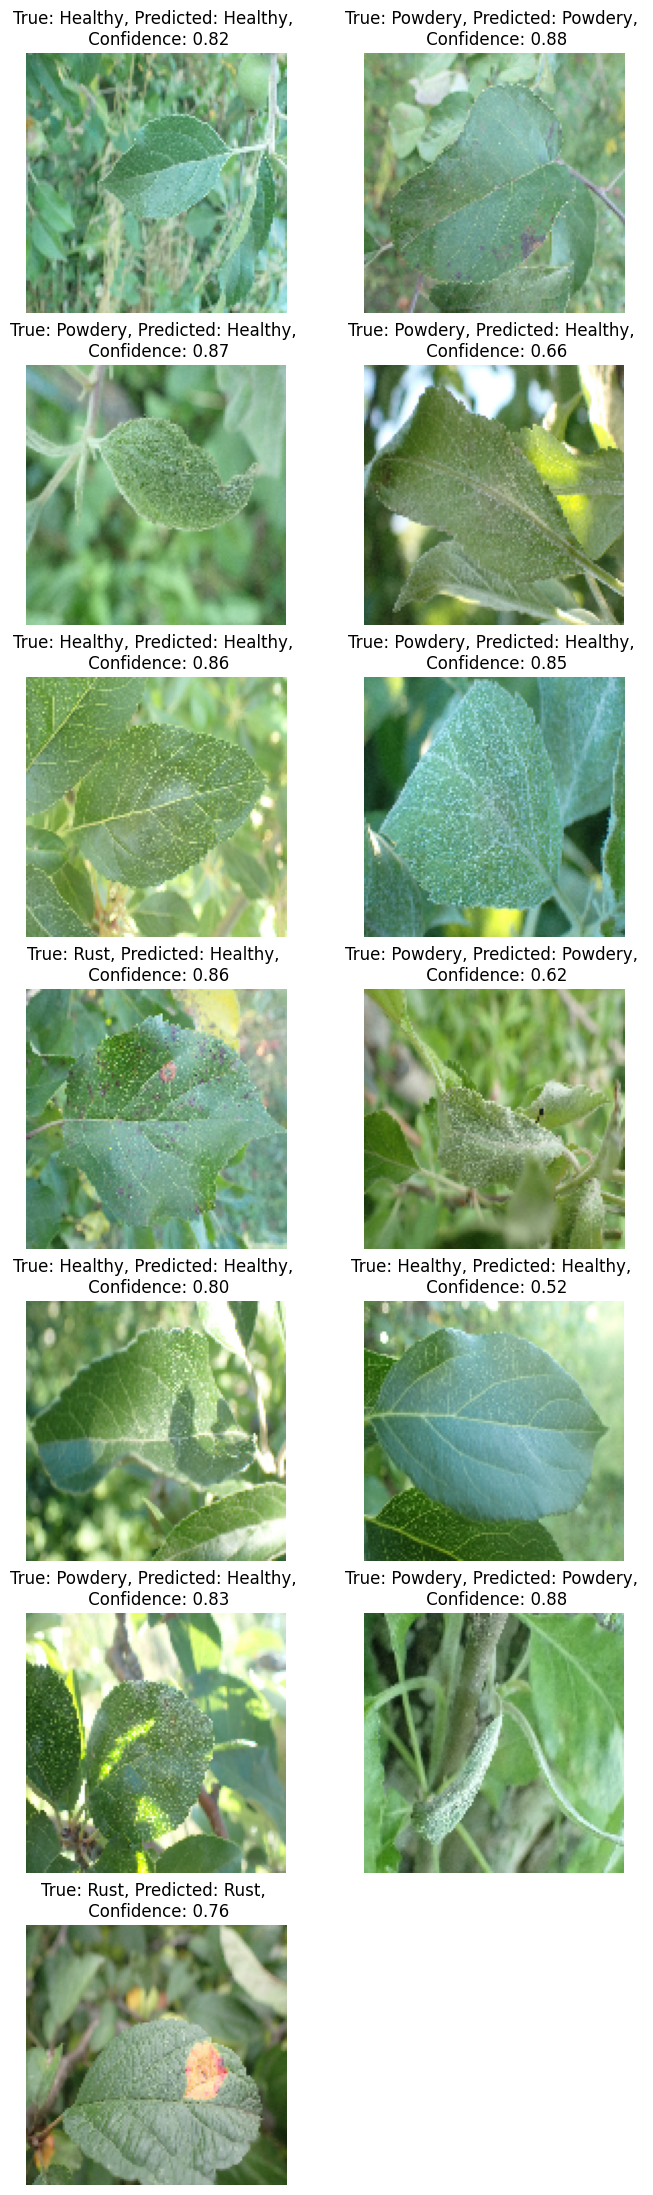

In [108]:
min_probs = np.where(pred_probabilities < 0.9)[0]
plt.figure(figsize=(8, 4*len(min_probs)))
for i, idx in enumerate(min_probs):
    plt.subplot(len(min_probs), 2, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {class_dict[true_labels[idx]]}, Predicted: {class_dict[pred_labels[idx]]}, \n Confidence: {pred_probabilities[idx]:.2f}")
    plt.axis('off')
plt.show()

By examining the image groups derived above, it can be found that in cases with misclassifications and in cases with model uncertainty, it was not observed to be diseased and categorised the leaf as healthy. More often than not, the model did not notice "Powdery". Which could be seen from the confusion matrix.